# Electrophysiology and Morphology Analysis

The electrophysiological (ephys) and morphological (morph) data, derived from patch-sequencing experiments (Scala et al., 2021, Nature), are combined with 10x 3’ v2 assay gene expression data to isolate MGE and CGE interneurons. We first compute Z-score differences between MGE and CGE cell types for both ephys and morph features to assess relative differences. A correlation matrix is then constructed to explore relationships between properties like input resistance, axon length, membrane time constant, and firing patterns. A scatterplot of input resistance vs. axon total length visualizes their relationship and structure-function connections. We also perform UMAP clustering to examine lower-dimensional data representations and distinguish cell type subclasses. Finally, we investigate how axon total length varies by cell type subclass, providing insights into their distinct physiological roles.

### 1.1 Import packages, data and convert to dataframe

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import tarfile
import io
import json
import umap.umap_ as umap # import umap
import gc # no longer used
import scipy.sparse as sparse
from scipy import stats
%whos

Variable               Type              Data/Info
--------------------------------------------------
KMeans                 ABCMeta           <class 'sklearn.cluster._kmeans.KMeans'>
LabelEncoder           type              <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
PCA                    ABCMeta           <class 'sklearn.decomposition._pca.PCA'>
StandardScaler         type              <class 'sklearn.preproces<...>ng._data.StandardScaler'>
ax                     Axes              Axes(0.125,0.11;0.775x0.77)
ax2                    Axes              Axes(0.125,0.11;0.775x0.77)
cge_avg                float64           0.2545454545454545
cge_ephys_morph_data   DataFrame                            AP Fan<...>\n[110 rows x 93 columns]
cge_gene_df            DataFrame                            ENSMUS<...>755 rows x 25502 columns]
cgedata                AnnData           AnnData object with n_obs<...>itle'\n    obsm: 'X_tsne'
col_names              list              n=84
colum

In [8]:
mgedata = sc.read_h5ad('c2c0a633-136f-4c97-ab51-062ce97ad802.h5ad')
cgedata = sc.read_h5ad('2d50c165-da20-47c4-9cbe-914f8a8b3211.h5ad')

In [9]:
mge_gene_df = mgedata.to_df()
cge_gene_df = cgedata.to_df()

In [10]:
mge_gene_df.index = mge_gene_df.index.str.replace('-.*$', '', regex=True)
cge_gene_df.index = cge_gene_df.index.str.replace('-.*$', '', regex=True)

In [12]:
mge_gene_df = mge_gene_df.iloc[:, np.flatnonzero(mge_gene_df.sum(axis = 0) != 0)]

print(f"There are {mge_gene_df.shape[0]} cells and {mge_gene_df.shape[1]} genes in the  mge count matrix:")

# Show the first 5 rows of the count matrix
mge_gene_df.head()

There are 12644 cells and 26290 genes in the  mge count matrix:


,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000103168,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000073953,ENSMUSG00000115784,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180213_sample_5,19.0,36.0,0.0,65.0,0.0,0.0,0.0,192.0,91.0,90.0,...,0.0,23.0,102.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0
20180215_sample_1,0.0,0.0,0.0,399.0,0.0,0.0,0.0,82.0,666.0,169.0,...,0.0,124.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180220_sample_1,9.0,0.0,0.0,21.0,0.0,0.0,0.0,69.0,12.0,7.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180225_sample_7,300.0,1.0,0.0,262.0,0.0,0.0,0.0,147.0,612.0,33.0,...,0.0,60.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180306_sample_1,0.0,0.0,0.0,96.0,0.0,0.0,0.0,83.0,20.0,185.0,...,2.0,36.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
cge_gene_df = cge_gene_df.iloc[:, np.flatnonzero(cge_gene_df.sum(axis = 0) != 0)]

print(f"There are {cge_gene_df.shape[0]} cells and {cge_gene_df.shape[1]} genes in the  mge count matrix:")

# Show the first 5 rows of the count matrix
cge_gene_df.head()

There are 15755 cells and 25502 genes in the  mge count matrix:


,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000103168,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000115784,ENSMUSG00000075161,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180417_sample_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20180425_sample_8,54.0,22.0,0.0,0.0,0.0,0.0,0.0,12.0,300.0,0.0,...,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,0.0
20180501_sample_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,47.0,21.0,...,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0
20180608_sample_1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,...,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
20180619_sample_7,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
ephys_df = pd.read_csv('m1_patchseq_ephys_features.csv').set_index('cell id')

In [15]:
morph_df = pd.read_csv('m1_patchseq_morph_features.csv').set_index('cell id')

In [18]:
ephys_morph_data = pd.merge(ephys_df, morph_df, left_index=True, right_index=True)
mge_ephys_morph_data = ephys_morph_data[ephys_morph_data.index.isin(mge_gene_df.index)]
cge_ephys_morph_data = ephys_morph_data[ephys_morph_data.index.isin(cge_gene_df.index)]

In [20]:
# Add lineage column
mge_ephys_morph_data['lineage'] = 'MGE'
cge_ephys_morph_data['lineage'] = 'CGE'

# Merge the two dataframes
merged_data = pd.concat([mge_ephys_morph_data, cge_ephys_morph_data])

/tmp/ipykernel_412/499174894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mge_ephys_morph_data['lineage'] = 'MGE'
/tmp/ipykernel_412/499174894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cge_ephys_morph_data['lineage'] = 'CGE'


In [70]:
merged_data.head()

,AP Fano factor,AP amplitude (mV),AP amplitude adaptation index,AP amplitude average adaptation index,AP coefficient of variation,AP threshold (mV),AP width (ms),Afterdepolarization (mV),Afterhyperpolarization (mV),Burstiness,...,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class,lineage
cell id,,,,,,,,,,,,,,,,,,,,,
20180911_sample_6,2.064471,93.378752,0.940638,0.988090,0.189996,-44.058077,1.00,0.000000,-12.100946,0.0,...,0.255,0.525971,9.093158,5.0,0.400000,0.400000,0.200000,5,inh,MGE
20180911_sample_3,1.352732,73.927954,0.927729,0.989310,0.175435,-38.192302,1.00,4.303075,-11.910219,0.0,...,0.035,0.126865,8.341728,8.0,0.375000,0.375000,0.250000,2/3,inh,MGE
20180905_sample_2,0.798646,81.581913,0.948411,0.988044,0.120466,-41.110732,0.96,3.084030,-16.066171,0.0,...,0.370,0.215916,10.358118,6.0,0.500000,0.333333,0.166667,2/3,inh,MGE
20180925_sample_9,1.117588,68.841565,0.959917,0.997770,0.151509,-35.629921,0.56,0.000000,-21.923926,0.0,...,0.330,0.553917,10.082119,6.0,0.166667,0.666667,0.166667,5,inh,MGE
20180926_sample_3,1.734870,68.847422,0.924876,0.996088,0.193675,-34.170035,0.64,0.000000,-20.816438,0.0,...,0.330,0.358796,9.293717,5.0,0.200000,0.600000,0.200000,5,inh,MGE


In [22]:
metadata_df = pd.read_csv('m1_patchseq_meta_data.csv', index_col = 'Cell', delimiter = '\t').rename_axis('cell id')
metadata_df = metadata_df[metadata_df.index.isin(merged_data.index)]

In [71]:
metadata_df.head()

,Number,Slice,Date,Sample,Mouse,Mouse date of birth,Mouse age,Mouse gender,Mouse genotype,Targeted layer,...,Length (bp),Yield (pg/µl),User,Hold Time (min),Soma depth (µm),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm),Traced,Exclusion reasons
cell id,,,,,,,,,,,,,,,,,,,,,
20180213_sample_5,80,20180213_slice_5,2018-02-13,sample 5,mouse_JDVRZ,2017-11-30,75,M,Pvalb-Cre/wt; Ai9/wt,6,...,2073,240.87,Fede,30.0,1250.3,443.7,601.1,1659.036,y,NaN
20180215_sample_1,81,20180215_slice_1,2018-02-15,sample 1,mouse_LBJDN,2017-11-30,77,F,Pvalb-Cre/wt; Ai9/wt,5,...,2153,85.85,Fede,40.0,920.1,340.9,615.4,1698.504,y,NaN
20180306_sample_1,91,20180306_slice_1,2018-03-06,sample 1,mouse_YMIOM,2018-01-10,55,M,Pvalb-Cre/wt; Ai9/wt,2/3,...,1629,110.05,Fede,40.0,441.4,152.6,626.5,1729.140,y,NaN
20180327_sample_1,121,20180327_slice_1,2018-03-27,sample 1,mouse_XECLH,2018-01-22,64,F,Pvalb-Cre/wt; Ai9/wt,5,...,2347,199.59,Fede,35.0,596,220.9,509.5,1406.220,y,NaN
20180327_sample_4,124,20180327_slice_4,2018-03-27,sample 4,mouse_XECLH,2018-01-22,64,F,Pvalb-Cre/wt; Ai9/wt,5,...,2146,170.38,Matteo,48.0,753.7,272.7,529.0,1460.040,y,NaN


In [24]:
subclass_info = ['RNA family', 'RNA type']
final_data = metadata_df[subclass_info].join(merged_data, how = 'inner')

In [72]:
final_data.head()

,RNA family,RNA type,AP Fano factor,AP amplitude (mV),AP amplitude adaptation index,AP amplitude average adaptation index,AP coefficient of variation,AP threshold (mV),AP width (ms),Afterdepolarization (mV),...,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class,lineage
cell id,,,,,,,,,,,,,,,,,,,,,
20180213_sample_5,Pvalb,Pvalb Gpr149,0.968643,73.841175,0.920466,0.997362,0.137817,-50.148241,0.56,0.0,...,0.440,0.753630,12.255737,7.0,0.285714,0.428571,0.285714,6,inh,MGE
20180215_sample_1,Pvalb,Pvalb Reln,0.190948,73.133346,0.933278,0.996312,0.056997,-38.167231,0.68,0.0,...,0.370,0.541712,16.709504,17.0,0.352941,0.411765,0.235294,5,inh,MGE
20180306_sample_1,Pvalb,Pvalb Reln,1.163175,72.697759,0.949927,0.997736,0.161340,-33.118788,0.52,0.0,...,0.550,0.255271,9.560878,6.0,0.166667,0.666667,0.166667,2/3,inh,MGE
20180327_sample_1,Pvalb,Pvalb Il1rapl2,0.994843,75.442925,0.940960,0.997319,0.137423,-39.938901,0.60,0.0,...,0.220,0.423831,7.696957,4.0,0.250000,0.750000,0.000000,5,inh,MGE
20180327_sample_4,Pvalb,Pvalb Reln,2.576478,75.576004,0.927375,0.996949,0.248114,-41.783281,0.60,0.0,...,0.515,0.516219,10.181503,4.0,0.000000,1.000000,0.000000,5,inh,MGE


### 1.2 Clean Data

In [31]:
data_cleaned_columns = final_data.dropna(axis=1, how='all')
columns_with_nans = data_cleaned_columns.columns[data_cleaned_columns.isna().any()]
print("Columns with NaNs:", columns_with_nans)
data_cleaned = data_cleaned_columns.dropna(axis=0, subset=columns_with_nans)
data_cleaned.head()

Columns with NaNs: Index(['EMD axon dendrite', 'Log1p fraction of axon above dendrite',
       'Log1p fraction of axon below dendrite',
       'Log1p fraction of dendrite above axon', 'dendrite above soma',
       'dendrite bifurcation standard deviation', 'dendrite branch points',
       'dendrite first bifurcation moment', 'dendrite height',
       'dendrite log max tortuosity', 'dendrite log median tortuosity',
       'dendrite log min tortuosity', 'dendrite max Euclidean dist',
       'dendrite max branch order', 'dendrite max path distance to soma',
       'dendrite max segment length', 'dendrite mean neurite radius',
       'dendrite robust height', 'dendrite robust width', 'dendrite tips',
       'dendrite total length', 'dendrite width', 'dendrite x-bias',
       'dendrite z-bias', 'stems', 'stems exiting down',
       'stems exiting to the sides', 'stems exiting up'],
      dtype='object')


,RNA family,RNA type,AP Fano factor,AP amplitude (mV),AP amplitude adaptation index,AP amplitude average adaptation index,AP coefficient of variation,AP threshold (mV),AP width (ms),Afterdepolarization (mV),...,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class,lineage
cell id,,,,,,,,,,,,,,,,,,,,,
20180213_sample_5,Pvalb,Pvalb Gpr149,0.968643,73.841175,0.920466,0.997362,0.137817,-50.148241,0.56,0.0,...,0.440,0.753630,12.255737,7.0,0.285714,0.428571,0.285714,6,inh,MGE
20180215_sample_1,Pvalb,Pvalb Reln,0.190948,73.133346,0.933278,0.996312,0.056997,-38.167231,0.68,0.0,...,0.370,0.541712,16.709504,17.0,0.352941,0.411765,0.235294,5,inh,MGE
20180306_sample_1,Pvalb,Pvalb Reln,1.163175,72.697759,0.949927,0.997736,0.161340,-33.118788,0.52,0.0,...,0.550,0.255271,9.560878,6.0,0.166667,0.666667,0.166667,2/3,inh,MGE
20180327_sample_1,Pvalb,Pvalb Il1rapl2,0.994843,75.442925,0.940960,0.997319,0.137423,-39.938901,0.60,0.0,...,0.220,0.423831,7.696957,4.0,0.250000,0.750000,0.000000,5,inh,MGE
20180327_sample_4,Pvalb,Pvalb Reln,2.576478,75.576004,0.927375,0.996949,0.248114,-41.783281,0.60,0.0,...,0.515,0.516219,10.181503,4.0,0.000000,1.000000,0.000000,5,inh,MGE


### 1.3 Describe General Data Statistics

In [32]:
data_cleaned['RNA family'].value_counts()

Pvalb    144
Sst      107
Vip       63
Lamp5     47
Name: RNA family, dtype: int64

In [33]:
data_cleaned.describe()

,AP Fano factor,AP amplitude (mV),AP amplitude adaptation index,AP amplitude average adaptation index,AP coefficient of variation,AP threshold (mV),AP width (ms),Afterdepolarization (mV),Afterhyperpolarization (mV),Burstiness,...,dendrite width,dendrite x-bias,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,...,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,2.142876,75.510774,0.885943,0.987519,0.203014,-35.434117,0.875679,0.391261,-13.715642,0.109229,...,241.500139,40.314765,-14.366150,0.266759,0.401687,11.662496,5.786704,0.283192,0.403399,0.313408
std,2.016717,10.343599,0.087262,0.019118,0.096343,6.786880,0.298387,1.168256,5.614642,0.211491,...,114.873422,37.088793,81.787435,0.134944,0.264821,5.325501,2.602657,0.170115,0.233441,0.172134
min,0.052140,41.941290,0.595276,0.813754,0.027179,-61.900418,0.440000,0.000000,-25.309832,0.000000,...,23.260000,0.020000,-338.020000,0.035000,0.031886,5.267043,1.000000,0.000000,0.000000,0.000000
25%,0.936325,68.515271,0.850633,0.985300,0.138499,-40.189344,0.640000,0.000000,-18.058483,0.000000,...,159.220000,15.060000,-55.870000,0.185000,0.170419,8.839593,4.000000,0.166667,0.250000,0.200000
50%,1.719319,75.569041,0.917345,0.992336,0.193128,-35.774007,0.840000,0.000000,-13.667248,0.000000,...,223.870000,29.840000,-13.170000,0.255000,0.342842,10.140183,6.000000,0.285714,0.400000,0.333333
75%,2.646698,82.663700,0.946139,0.996589,0.242905,-30.598646,1.040000,0.000000,-9.577904,0.000000,...,314.570000,54.510000,23.520000,0.330000,0.597050,12.375728,7.000000,0.400000,0.500000,0.428571
max,18.653379,102.402162,1.039344,1.012783,0.797021,-14.553822,2.200000,6.288700,7.590160,0.809881,...,760.860000,269.890000,205.190000,0.770000,0.980520,56.830685,20.000000,1.000000,1.000000,1.000000


### 2.1 Differential Feature Analysis

Z-scores of differences between MGE and CGE:
[-0.13130283 -0.13638632 -0.13062349 -0.13072626 -0.13075651 -0.13320052
 -0.13114464 -0.13050277 -0.13599121 -0.13095262 -0.13073966 -0.13113946
 -0.13086691 -0.13085154 -0.24554923 -0.12398558 -0.1282244  -0.10108667
 -0.12917973 -0.13176954 -0.13100804 -0.1316767  -0.09893213 -0.1305713
 -0.13072866 -0.13072877 -0.13063416 -0.13177402 -0.13242293 -0.13065978
 -0.13059299 -0.13078268 -0.13079606 -0.13037979 -0.11258381 -0.04446173
 -0.04092806  0.03497815 -0.1307508  -0.03370792 -0.12677806  0.08130153
 -0.07280296 -0.13072792 -0.1355126  -0.05044121 -0.03228108 -0.04194425
  8.877267    0.04518839 -0.1243086   0.07389868 -0.13078232 -0.14222333
 -0.1376188  -0.13958185 -0.11755984 -0.13085151 -0.13073742 -0.13071437
 -0.11180314 -0.13227342 -0.11696723 -0.10153332 -0.13066796 -0.12722178
 -0.07593627 -0.13707842 -0.12995212 -0.06797813 -0.12800029 -0.16590432
 -0.13065422 -0.13058266 -0.12958735 -0.1300861  -0.13078428 -0.13065466
 -0.130

/tmp/ipykernel_412/1437594134.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(numeric_cols, rotation=90)  # Rotate x-axis ticks by 45 degrees


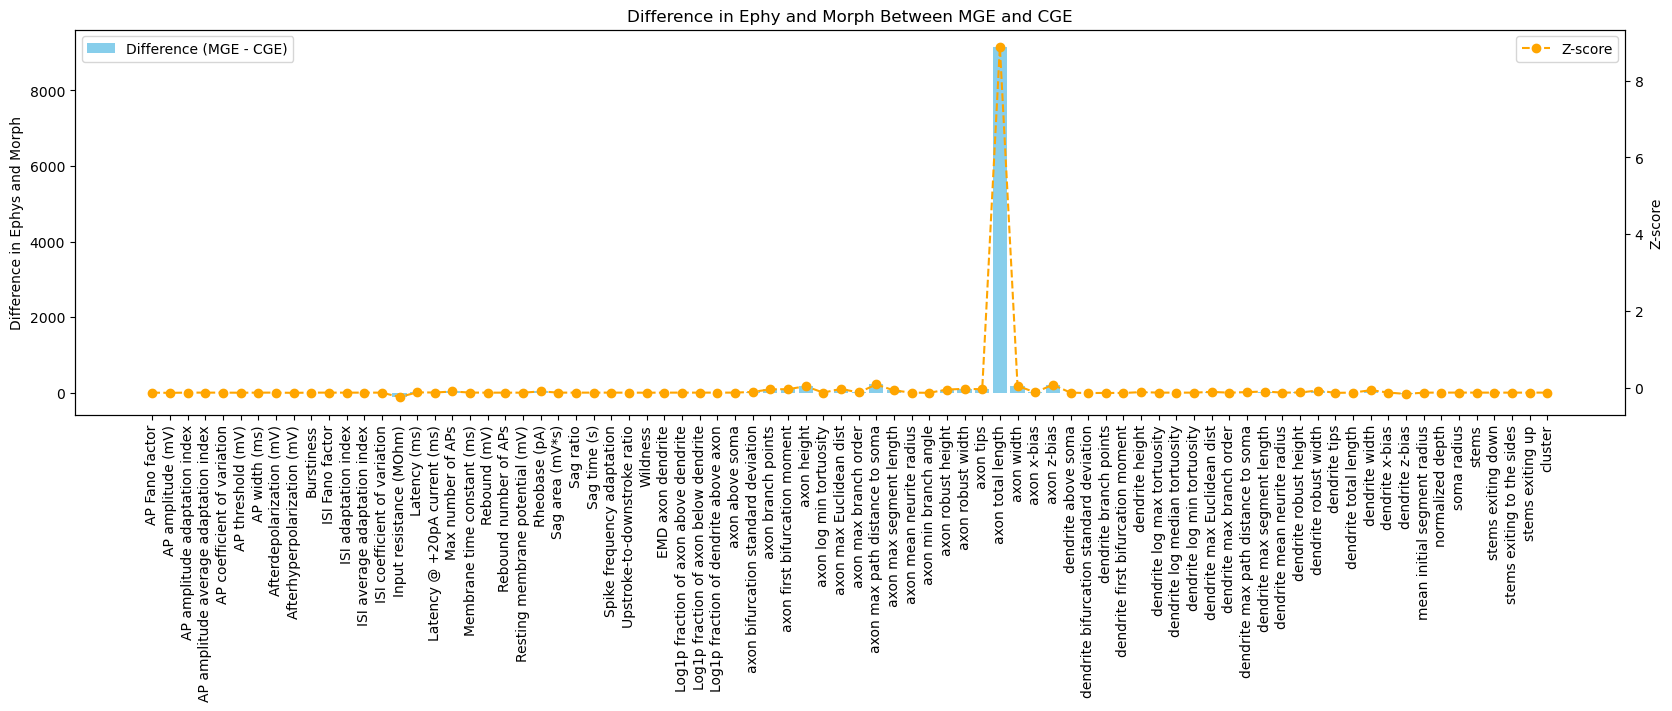

In [45]:
differences = []
numeric_cols = data_cleaned.select_dtypes(include=['number']).columns
for metric in numeric_cols:
    # Get the data for the gene across both subclasses
    mge_avg = data_cleaned[data_cleaned['lineage'] == 'MGE'][metric].mean()
    cge_avg = data_cleaned[data_cleaned['lineage'] == 'CGE'][metric].mean()
    
    # Calculate the difference between Pvalb and Sst averages
    differences.append(mge_avg - cge_avg)

# Z-score of the differences
diff_zscore = stats.zscore(differences)

print("Z-scores of differences between MGE and CGE:")
print(diff_zscore)

# Plot the differences and Z-scores
fig, ax = plt.subplots(figsize=(20, 5))

# Plot the differences
ax.bar(numeric_cols, differences, color='skyblue', label="Difference (MGE - CGE)")
ax.set_ylabel("Difference in Ephys and Morph")
ax.set_title("Difference in Ephy and Morph Between MGE and CGE")

# Plot the Z-scores on the same axis
ax2 = ax.twinx()  # Create a second y-axis for Z-scores
ax2.plot(numeric_cols, diff_zscore, color='orange', marker='o', linestyle='dashed', label="Z-score")
ax2.set_ylabel("Z-score")
ax.set_xticklabels(numeric_cols, rotation=90)  # Rotate x-axis ticks by 45 degrees


# Show the plot
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### 2.2 Correlation Matrix of Ephys and Morph Features

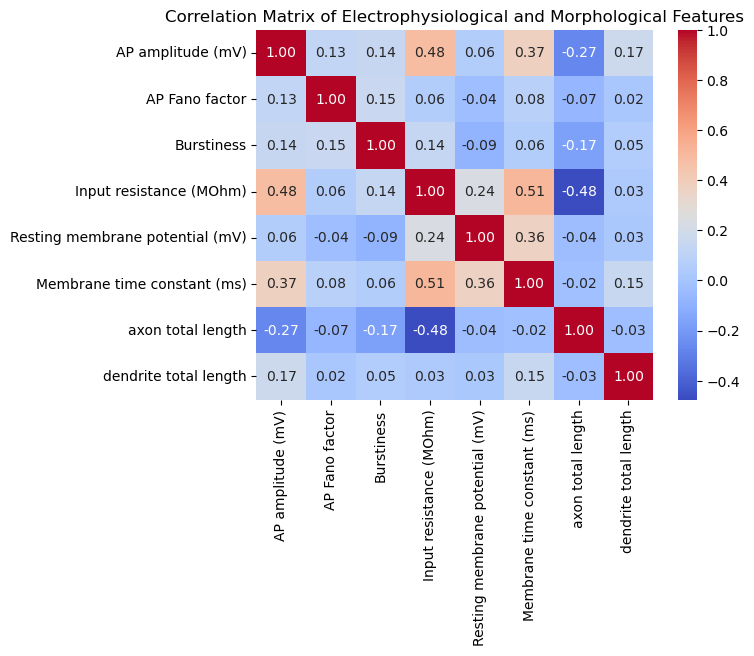

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for the correlation matrix
correlation_data = data_cleaned[['AP amplitude (mV)', 'AP Fano factor', 'Burstiness', 
                         'Input resistance (MOhm)', 'Resting membrane potential (mV)', 
                         'Membrane time constant (ms)', 'axon total length', 'dendrite total length']]
corr_matrix = correlation_data.corr()

# Plot heatmap of correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Electrophysiological and Morphological Features')
plt.show()

### 2.3 Scatterplot of Important Features

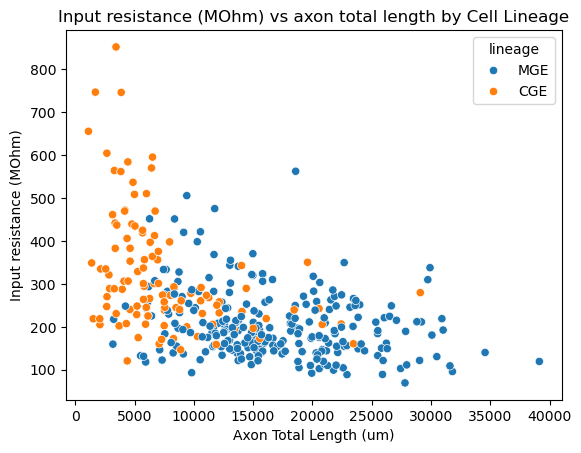

In [48]:
sns.scatterplot(x='axon total length', y='Input resistance (MOhm)', hue='lineage', data=data_cleaned)
plt.title('Input resistance (MOhm) vs axon total length by Cell Lineage')
plt.xlabel('Axon Total Length (um)')
plt.ylabel('Input resistance (MOhm)')
plt.show()

### 2.4 SVM Classifier and PCA

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       1.00      0.91      0.95        23

    accuracy                           0.97        73
   macro avg       0.98      0.96      0.97        73
weighted avg       0.97      0.97      0.97        73



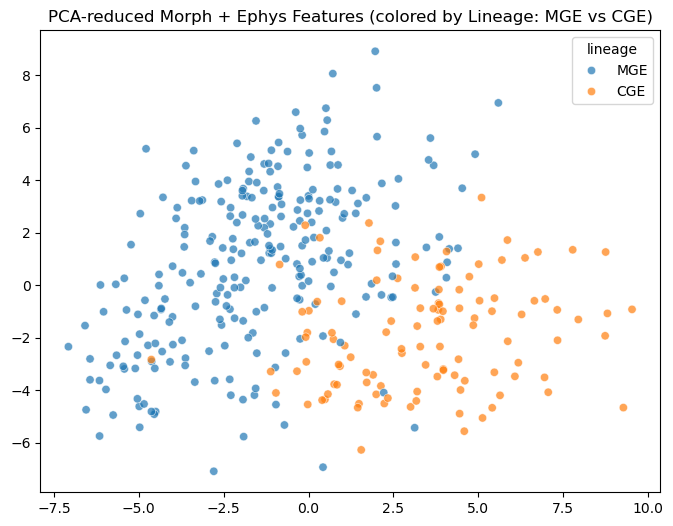

In [75]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Select input features and target
X = data_cleaned[numeric_cols]
y = data_cleaned['lineage'].map({'MGE': 0, 'CGE': 1})  # MGE=0, CGE=1

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM pipeline with scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict the test set
y_pred = svm_pipeline.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))

from sklearn.decomposition import PCA

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Plot the reduced data
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_cleaned['lineage'], alpha=0.7)
plt.title("PCA-reduced Morph + Ephys Features (colored by Lineage: MGE vs CGE)")
plt.show()


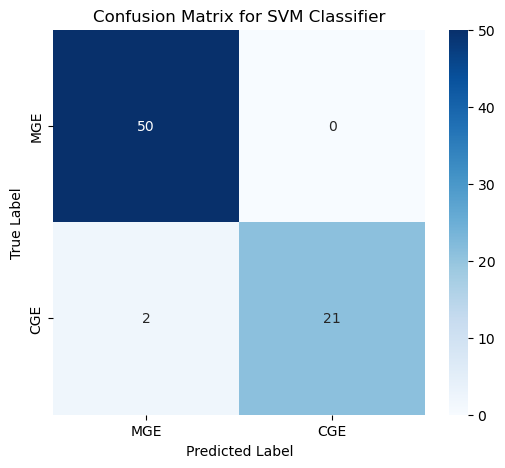

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['MGE', 'CGE'], yticklabels=['MGE', 'CGE'])
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.5 Unsupervised KMeans Clustering using PCA-reduced Features

/tmp/ipykernel_412/504406830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['cluster'] = kmeans.fit_predict(scaled_features)


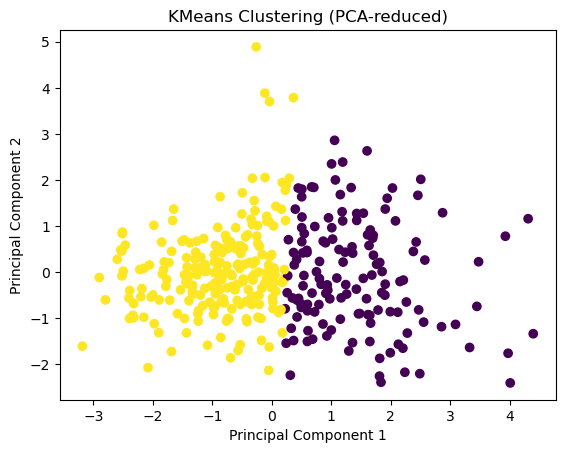

In [39]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # Set an appropriate number of clusters
data_cleaned['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clustering result
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_cleaned['cluster'])
plt.title('KMeans Clustering (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### 3.1 Comparing Highly Differential Features by Cell Type

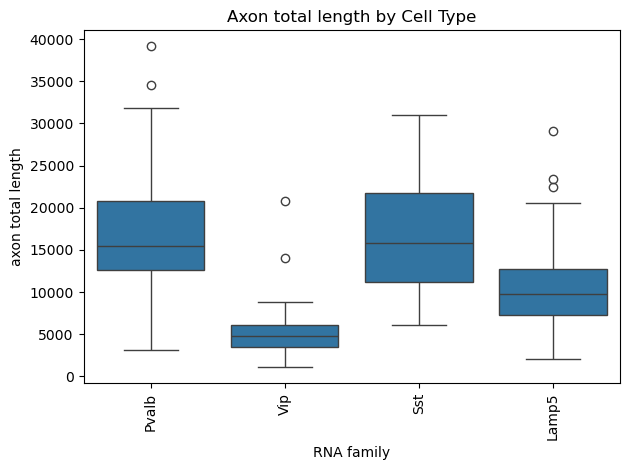

In [79]:
sns.boxplot(x='RNA family', y='axon total length', data=data_cleaned)
plt.title('Axon total length by Cell Type')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### 3.2 UMAP clustering of Ephys and Morph features by Cell Type

<Axes: >

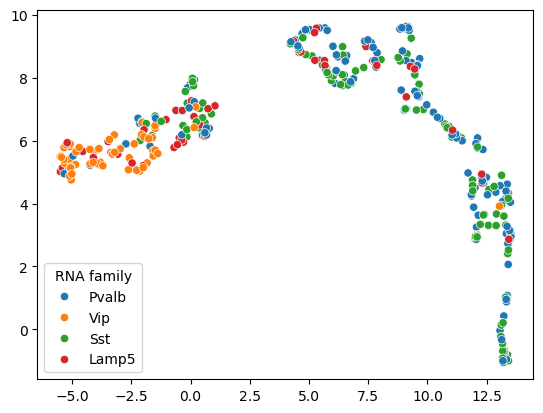

In [60]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(data_cleaned[numeric_cols])

sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=data_cleaned['RNA family'])

# Summary

The analysis reveals some important insights about interneuron subtypes. MGE-derived interneurons had longer axon lengths compared to CGE-derived cells, which may explain their ability to induce plasticity through enhanced synaptic connectivity and long distance signaling mechanisms. There's a negative correlation between input resistance and axon length, suggesting that cells with longer axons tend to have lower input resistance, suggesting a relationship between the structural elements of these interneurons and their functional roles. An SVM classifier accurately distinguishes MGE and CGE cells based on their ephys and morph features, and K-means clustering supports these classifications, demonstrating that these subpopulations are reliably distinguishable and have characteristic features. VIP and LAMP5 cells have shorter axons, potentially indicating their unique roles in local inhibition of cortical circuits. UMAP clustering shows that SST and PVALB cells cluster together, suggesting similar features and the need for further investigation. However, PV and SST neurons appear indistinguishable when UMAP clustering is peformed on their electrophysiological and morphological properties, suggesting that 